## Vanitas Object Recognition Demo


In [7]:
import os

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

import numpy as np

from mrcnn import visualize
from vanitas_utils import VanitasDataset, VanitasConfig

## Dataset

In [8]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = VanitasDataset()
VANITAS_DIR = os.path.join(ROOT_DIR, "data/vanitas_json")
dataset.load_vanitas(VANITAS_DIR, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 50
Class Count: 28
  0. BG                                                
  1. Skull                                             
  2. Hourglass                                         
  3. Globe                                             
  4. Coins                                             
  5. Butterfly                                         
  6. Flowers                                           
  7. Watch                                             
  8. Dice                                              
  9. Fruit                                             
 10. Violin                                            
 11. Lute                                              
 12. Flute                                             
 13. Candle                                            
 14. Inkstand                                          
 15. Music                                             
 16. Bubble                                            
 17. Lamp       

## Load and display randsamples

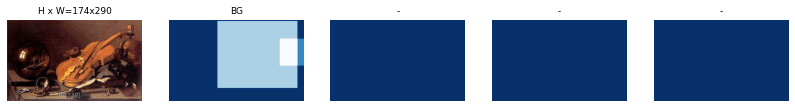

[0 0]


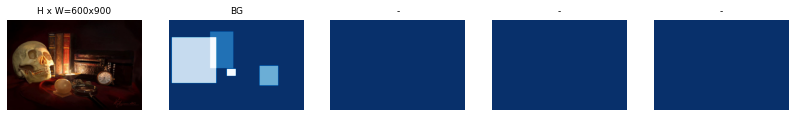

[0 0 0 0]


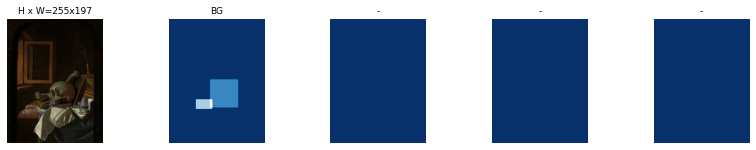

[0 0]


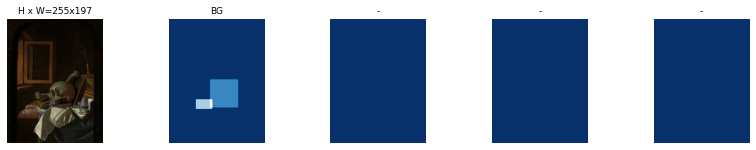

[0 0]


In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    print(class_ids)